# Quantifying bias associated with failure to consider risk-risk correlation

The purpose of this notebook is to walk through scenarios in which failing to consider the correlation between two (or more) risk factors may result in biased estimates in vivarium simulations and provide functions that allow quantification of this bias in a "back of the envelope" type fashion for an entire population (not stratified by age or sex, etc.). Functions are provided both for dichotomous and continuous risk factors for convenience and can be applied/adapted to specific model contexts in order to determine if modeling risk-risk correlation will be important for answering a given research question with vivarium.

In [2]:
import pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt
import scipy

# Scenario 1: Correlation between intervention selection factors and its influence on proportion of the population eligible for the intervention (and therefore the *population-level* impact of the intervention)

Assume two dichotomous risks that are 100% associated with intervention (presence of R1 and R2 necessary to receive intervention).

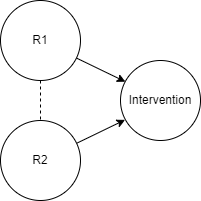

Note that the bias associated with failing to consider the correlation between R1 and R2 in this case affects the proportion of the population eligible for the intervention - therefore, this bias may not be a concern if the outcome will be stratified by intervention coverage.

Additionally note that in this situation that there is effect modification of the effect of R1 on the intervention via R2 (and vise-versa). If we were to calculate a PAF of the correlated R1 and R2 risks on the intervention, we could not do so using the method described on the risk-risk correlation page due to the presence of this effect modification.

An applied example in which the balaned energy protein antenatal supplementation intervention is only available to those with low BMI in pregnancy who attend antenatal care visits:



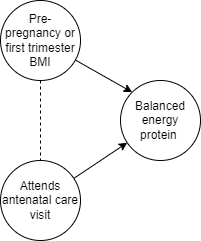

In [2]:
"""
Calculates absolute and relative error in the proportion of the population eligible for
a hypothetical intervention under the assumption that the presence of both R1 and R2 dichotomous
risks is required for intervention eligibility and an assumed measure of correlation (rho).

Absolute error is defined as eligible population proportion without considering correlation minus
the population proportion with correlation considered.

Relative error is defined as the absolute error divided by the eligible population proportion with
correlation considered.
"""

def calculate_bias_dichotomous_risks(r1_exposure,
                                      r2_exposure,
                                      rho,
                                      N):
    np.random.seed(1)
    probit_propensity = np.random.multivariate_normal([0,0], [[1, rho], [rho, 1]], size=N)
    propensity = scipy.stats.norm().cdf(probit_propensity)

    df = pd.DataFrame(index=range(N))
    df['risk1_propensity'] = propensity[:,0]
    df['risk2_propensity'] = propensity[:,1]
    df['risk1_exposure'] = np.where(df.risk1_propensity <= r1_exposure, 1, 0)
    df['risk2_exposure'] = np.where(df.risk2_propensity <= r2_exposure, 1, 0)
    
    uncorrelated_eligibility = r1_exposure * r2_exposure
    correlated_eligibility = len(df.loc[(df.risk1_exposure==1)&(df.risk2_exposure==1)]) / len(df)
    
    absolute_bias = uncorrelated_eligibility - correlated_eligibility
    relative_bias = absolute_bias / correlated_eligibility
    
    return absolute_bias, relative_bias

In [3]:
# Example call with output interpretation

calculate_bias_dichotomous_risks(r1_exposure=0.3,
                                      r2_exposure=0.5,
                                      rho=0.5,
                                      N=10_000)

# Given the defined parameter values, failing to consider the correlation between R1 and R2 will result in
# An underestimation of the percent of the population eligible for the intervention equal to 7.94 percentage points, 
# or a 34% underestimation of the eligible population size if we were to consider the correlation between R1 and R2

(-0.0794, -0.34612031386224934)

Text(0.5, 0, 'R1 exposure')

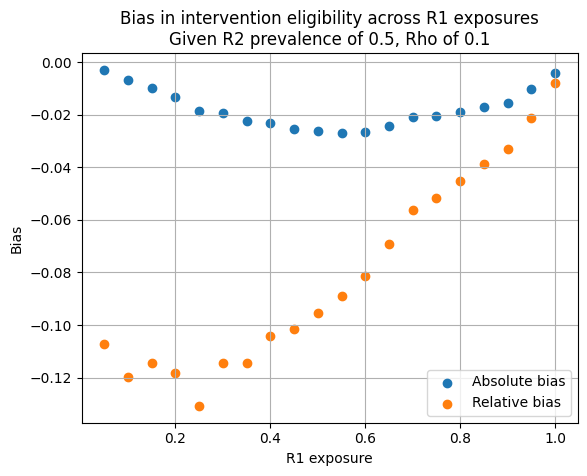

In [4]:
plt.figure()
for exp in np.linspace(0.05, 1.0, num=20):
    absolute_bias, relative_bias = calculate_bias_dichotomous_risks(exp, 0.5, 0.1, 10_000)
    plt.scatter(exp, absolute_bias, color='tab:blue')
    plt.scatter(exp, relative_bias, color='tab:orange')
plt.grid()
plt.title('Bias in intervention eligibility across R1 exposures\nGiven R2 prevalence of 0.5, Rho of 0.1')
plt.legend(['Absolute bias','Relative bias'])
plt.ylabel('Bias')
plt.xlabel('R1 exposure')

Text(0.5, 0, 'R1 exposure')

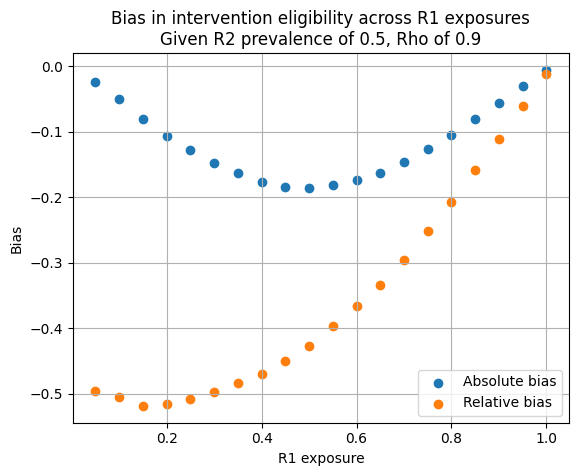

In [5]:
plt.figure()
for exp in np.linspace(0.05, 1.0, num=20):
    absolute_bias, relative_bias = calculate_bias_dichotomous_risks(exp, 0.5, 0.9, 10_000)
    plt.scatter(exp, absolute_bias, color='tab:blue')
    plt.scatter(exp, relative_bias, color='tab:orange')
plt.grid()
plt.title('Bias in intervention eligibility across R1 exposures\nGiven R2 prevalence of 0.5, Rho of 0.9')
plt.legend(['Absolute bias','Relative bias'])
plt.ylabel('Bias')
plt.xlabel('R1 exposure')

Text(0.5, 0, 'Rho')

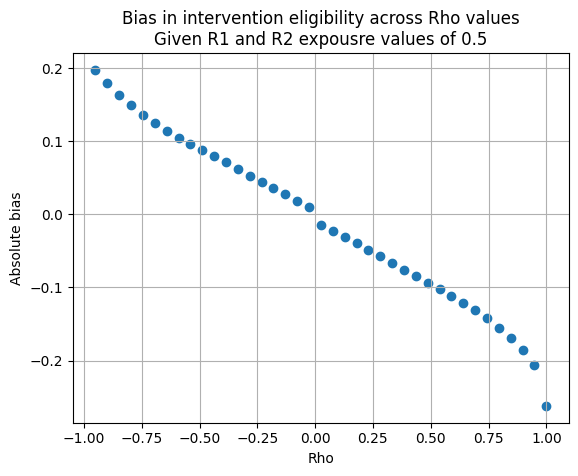

In [6]:
plt.figure()
for exp in np.linspace(-0.95, 1.0, num=39):
    absolute_bias, relative_bias = calculate_bias_dichotomous_risks(0.5, 0.5, exp, 10_000)
    plt.scatter(exp, absolute_bias, color='tab:blue')
plt.grid()
plt.title('Bias in intervention eligibility across Rho values\nGiven R1 and R2 expousre values of 0.5')
plt.ylabel('Absolute bias')
plt.xlabel('Rho')

Text(0.5, 0, 'Rho')

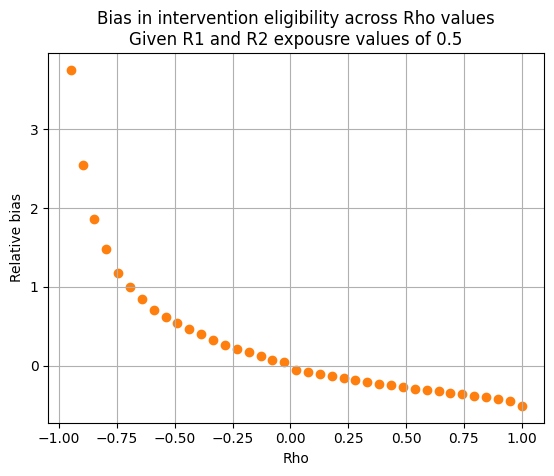

In [7]:
plt.figure()
for exp in np.linspace(-0.95, 1.0, num=39):
    absolute_bias, relative_bias = calculate_bias_dichotomous_risks(0.5, 0.5, exp, 10_000)
    plt.scatter(exp, relative_bias, color='tab:orange')
plt.grid()
plt.title('Bias in intervention eligibility across Rho values\nGiven R1 and R2 expousre values of 0.5')
plt.ylabel('Relative bias')
plt.xlabel('Rho')

In [8]:
# now for continuous risks
def calculate_bias_normal_risks(r1_mean, r1_sd, r1_threshold,
                                r2_mean, r2_sd, r2_threshold,
                                rho,
                                N):
    np.random.seed(1)
    probit_propensity = np.random.multivariate_normal([0,0], [[1, rho],
                                                         [rho, 1]], size=N)
    propensity = scipy.stats.norm().cdf(probit_propensity)

    df = pd.DataFrame(index=range(N))    
    df['risk1_exposure'] = scipy.stats.norm(r1_mean, r1_sd).ppf(propensity[:,0])
    df['risk2_exposure'] = scipy.stats.norm(r2_mean, r2_sd).ppf(propensity[:,0])
    uncorrelated_eligibility = (len(df.loc[df.risk1_exposure>=r1_threshold])/len(df)
                                * len(df.loc[df.risk2_exposure>=r2_threshold])/len(df))
    correlated_eligibility = len(df.loc[(df.risk1_exposure>=r1_threshold)
                                        &(df.risk2_exposure>=r2_threshold)]) / len(df)
    absolute_bias = uncorrelated_eligibility - correlated_eligibility
    relative_bias = absolute_bias / correlated_eligibility
    return absolute_bias, relative_bias

# Scenario 2: When the intervention targeting factor is associated with a risk affected by the intervention

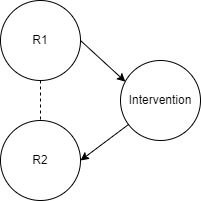

NOTE: for the sake of simplicity, we will assume that R1 and R2 do not affect the same outcome. This is because if R1 and R2 affected the same outcome we would need to calculate a joint PAF between R1 and R2 on the outcome, which would introduce additional sources of bias. Therefore, we will assess the impact of failing to consider the correlation between R1 and R2 demonstrated in the figure above on the intervention impact on the population average relative risk of R2 (which should be proportional to the intervention effect on outcome(s) affected by R2)

Also note that if there is non-zero baseline coverage of this intervention in the population, then initializing the simulated population with respect to R1 and R2 exposures as well as intervention coverage will be difficult in considering both the causal as well as total association between R1 and R2 (some of the correlation between R1 and R2 is mediated by the intervention and we must ensure that the intervention effect size is implemented as well as the correlation between R1 and R2 is accurately represented upon initialization).

**Some applied examples:**

Below is an example in which we've modeled the correlation between pre-pregnancy/first trimester BMI with infant birth weight in order to capture a less biased estimate of the impact of balanced energy protein antenatal supplementation targeted to low BMI pregnancies on infant mortality through its effect on infant birthweight. In this case, pre-pregnancy/first trimester BMI is the targeting factor that is associated with the other risk affected by the intervention (infant birthweight) that affects the outcome of interest, infant mortality.


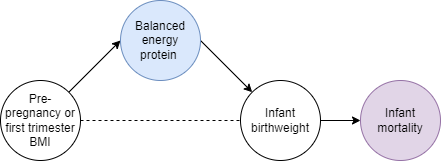

Further, if BEP additionally impacts child growth failure (which is associated with infant birthweight), then it would also be potentially important to model the correlation between pre-pregnancy/first trimester BMI and child growth failure (here shown as associated with one another through their respective associations with infant birthweight) in addition to the correlation between pre-pregnancy/first trimester BMI and infant birthweight.

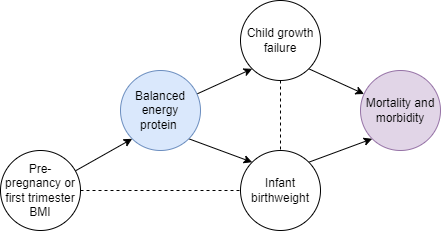

The following is an example of small quantity lipid-based supplementation (SQ-LNS) products (which improve stunting and wasting exposures) targeted to those with mild wasting. As shown in this limited diagram, modeling the correlation between wasting and stunting may be important in this scenario given that stunting (a risk affected by the intervention and that affects the outcome of interest, child morbidity and mortality) is correlated with wasting (the intervention targeting factor). 
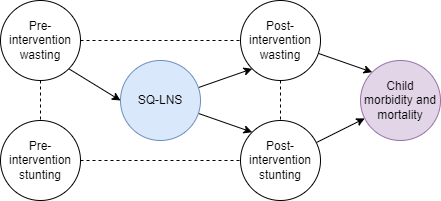

In [9]:
"""
Calculates absolute and relative error in the change in pre and post intervention
population average R2 relative risk for outcome O2 in the diagram above.
Assumes R1 and R2 are dichotomous risk factors with the
defined values for R1 exposure, R2 exposure, correlation between R1 and R2 (rho), 
and the intervention effect on R2 (probability that intervention will change exposure
status of R2 from exposed to unexposed given intervention elibility (R1 exposure)).

Absolute error is defined as the difference in pre- and post-intervention population
average R2 relative risk while failing to consider R1 and R2 correlation and while 
considering the R1 and R2 correlation, as a proportion of the difference while considering
the R1 and R2 correlation.

Relative error is defined as the difference in the in post-intervention population
average R2 relative risk as a fraction of the pre-intervention value in while failing 
to consider R1 and R2 correlation and considering the R1 and R2 correlation, 
as a proportion of the difference while considering
the R1 and R2 correlation.
"""
# note that the absolute scale is what we typically measure for "cases averted" due to an intervention


def scenario_2_dichotomous_risks(r1_exp, r2_exp, rho, int_r2_rr, N):
    np.random.seed(1)
    df = pd.DataFrame(index=range(N))
    probit_propensity = np.random.multivariate_normal([0,0], [[1, rho],
                                                         [rho, 1]], size=N)
    propensity = scipy.stats.norm().cdf(probit_propensity)
    df['r1_pre'] = np.where(propensity[:,0] <= r1_exp, 1, 0)
    df['intervention_effect_propensity'] = np.random.uniform(0, 1, size=len(df))
    df['r2_pre_correlated'] = np.where(propensity[:,1] <= r2_exp, 1, 0)
    df['r2_post_correlated'] = np.where((df.r1_pre==1) & (df.intervention_effect_propensity >= int_r2_rr),
                                        0, df.r2_pre_correlated)
    np.random.shuffle(propensity[:,1]) 
    intervention_effect_propensities = df.intervention_effect_propensity.values
    np.random.shuffle(intervention_effect_propensities)
    df['intervention_effect_propensity'] = intervention_effect_propensities
    df['r2_pre_uncorrelated'] = np.where(propensity[:,1] <= r2_exp, 1, 0)
    df['r2_post_uncorrelated'] = np.where((df.r1_pre==1) & (df.intervention_effect_propensity >= int_r2_rr),
                                        0, df.r2_pre_uncorrelated)

    for measure in ['correlated','uncorrelated']:
        df[f'abs_change_{measure}'] = df[f'r2_pre_{measure}'].mean() - df[f'r2_post_{measure}'].mean() # prevalence diff
        df[f'rel_change_{measure}'] = df[f'r2_post_{measure}'].mean() / df[f'r2_pre_{measure}'].mean() #

    abs_bias_pct = (df.abs_change_uncorrelated.mean() - df.abs_change_correlated.mean()) / df.abs_change_correlated.mean()
    rel_bias_pct = (df.rel_change_correlated.mean() - df.rel_change_uncorrelated.mean())# / df.rel_change_correlated.mean()

    return abs_bias_pct, rel_bias_pct

In [10]:
# default parameter values
r1_exp=0.5
r2_exp=0.5
rho=0.5
int_r2_rr=0.5
N=1_000_000

In [11]:
scenario_2_dichotomous_risks(r1_exp=r1_exp, 
                             r2_exp=r2_exp, 
                             rho=rho, 
                             int_r2_rr=int_r2_rr, 
                             N=N)

# bias on absolute and relative scales

(-0.2512614307801082, -0.08380704531644712)

In [12]:
scenario_2_dichotomous_risks(r1_exp=1, # effectively removes influence of targeting
                             r2_exp=r2_exp, 
                             rho=rho, 
                             int_r2_rr=int_r2_rr, 
                             N=N)

# no bias if not targeting
# small bias here due to randomness

(0.0005523048722886117, 0.0002758322939645508)

C:\Users\alibow\AppData\Local\Temp\ipykernel_12556\3641140503.py:46: RuntimeWarning: invalid value encountered in scalar divide
  abs_bias_pct = (df.abs_change_uncorrelated.mean() - df.abs_change_correlated.mean()) / df.abs_change_correlated.mean()


Text(0.5, 0, 'R1 exposure')

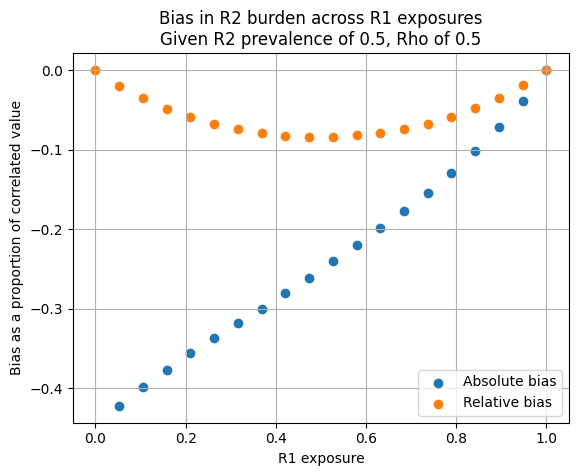

In [13]:
plt.figure()
for val in np.linspace(0, 1.0, num=20):
    abs_bias, rel_bias = scenario_2_dichotomous_risks(r1_exp=val, 
                             r2_exp=r2_exp, 
                             rho=rho, 
                             int_r2_rr=int_r2_rr, 
                             N=N)
    plt.scatter(val, abs_bias, color='tab:blue')
    plt.scatter(val, rel_bias, color='tab:orange')
plt.grid()
plt.title('Bias in R2 burden across R1 exposures\nGiven R2 prevalence of 0.5, Rho of 0.5')
plt.legend(['Absolute bias','Relative bias'])
plt.ylabel('Bias as a proportion of correlated value')
plt.xlabel('R1 exposure')

C:\Users\alibow\AppData\Local\Temp\ipykernel_12556\3641140503.py:44: RuntimeWarning: invalid value encountered in scalar divide
  df[f'rel_change_{measure}'] = df[f'r2_post_{measure}'].mean() / df[f'r2_pre_{measure}'].mean() #
C:\Users\alibow\AppData\Local\Temp\ipykernel_12556\3641140503.py:44: RuntimeWarning: invalid value encountered in scalar divide
  df[f'rel_change_{measure}'] = df[f'r2_post_{measure}'].mean() / df[f'r2_pre_{measure}'].mean() #
C:\Users\alibow\AppData\Local\Temp\ipykernel_12556\3641140503.py:46: RuntimeWarning: invalid value encountered in scalar divide
  abs_bias_pct = (df.abs_change_uncorrelated.mean() - df.abs_change_correlated.mean()) / df.abs_change_correlated.mean()


Text(0.5, 0, 'R2 exposure')

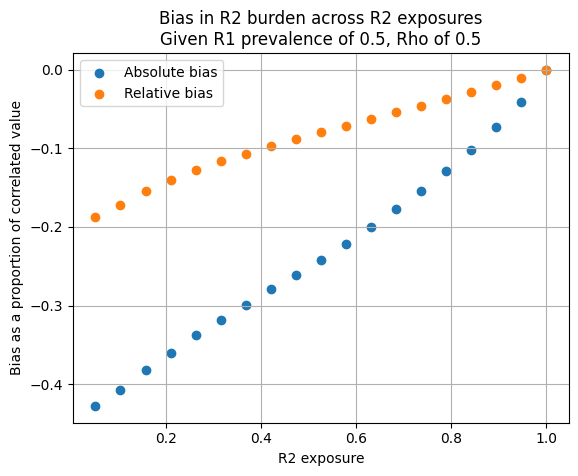

In [14]:
plt.figure()
for val in np.linspace(0, 1.0, num=20):
    abs_bias, rel_bias = scenario_2_dichotomous_risks(r1_exp=r1_exp, 
                             r2_exp=val, 
                             rho=rho, 
                             int_r2_rr=int_r2_rr, 
                             N=N)
    plt.scatter(val, abs_bias, color='tab:blue')
    plt.scatter(val, rel_bias, color='tab:orange')
plt.grid()
plt.title('Bias in R2 burden across R2 exposures\nGiven R1 prevalence of 0.5, Rho of 0.5')
plt.legend(['Absolute bias','Relative bias'])
plt.ylabel('Bias as a proportion of correlated value')
plt.xlabel('R2 exposure')

Text(0.5, 0, 'Rho')

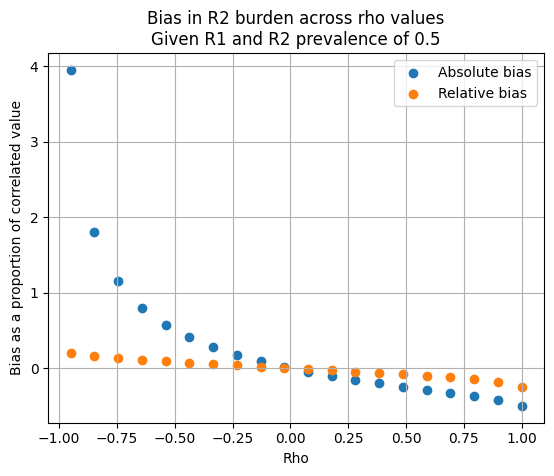

In [15]:
plt.figure()
for val in np.linspace(-0.95, 1.0, num=20):
    abs_bias, rel_bias = scenario_2_dichotomous_risks(r1_exp=r1_exp, 
                             r2_exp=r2_exp, 
                             rho=val, 
                             int_r2_rr=int_r2_rr, 
                             N=N)
    plt.scatter(val, abs_bias, color='tab:blue')
    plt.scatter(val, rel_bias, color='tab:orange')
plt.grid()
plt.title('Bias in R2 burden across rho values\nGiven R1 and R2 prevalence of 0.5')
plt.legend(['Absolute bias','Relative bias'])
plt.ylabel('Bias as a proportion of correlated value')
plt.xlabel('Rho')

In [16]:
"""
Calculates absolute and relative error in the change in pre and post intervention
population average R2 relative risk for outcome O2 in the diagram above, assuming
R1 and R2 are continuous, normally-distributed risk factors with the
defined input parameter values

Absolute error is defined as the difference in pre- and post-intervention population
average R2 relative risk while failing to consider R1 and R2 correlation and while 
considering the R1 and R2 correlation, as a proportion of the difference while considering
the R1 and R2 correlation.

Relative error is defined as the difference in the in post-intervention population
average R2 relative risk as a fraction of the pre-intervention value in while failing 
to consider R1 and R2 correlation and considering the R1 and R2 correlation, 
as a proportion of the difference while considering
the R1 and R2 correlation.
"""

def scenario_2_continuous_risks(r1_mean, 
                                r1_sd, 
                                r2_mean, 
                                r2_sd, 
                                r2_tmrel, # for effect on O2
                                r2_rr, # for effect on O2
                                rho, # between R1 and R2
                               
                               r2_delta, # intervention mean difference on R2 exposure
                               r1_threshold, # those with exposure greater than threshold get intervention
                               
                               N):
    np.random.seed(1)
    df = pd.DataFrame(index=range(N))
    probit_propensity = np.random.multivariate_normal([0,0], [[1, rho],
                                                         [rho, 1]], size=N)
    propensity = scipy.stats.norm().cdf(probit_propensity)
    df['r1_pre'] = scipy.stats.norm(r1_mean, r1_sd).ppf(propensity[:,0])
    df['r2_pre_correlated'] = scipy.stats.norm(r2_mean, r2_sd).ppf(propensity[:,1])
    r2_propensities_shuffled = propensity[:,1]
    np.random.shuffle(r2_propensities_shuffled) 
    # shuffling propensities rather than randomly resampling to ensure exactly the same marginal R2 exposure distribution
    df['r2_pre_uncorrelated'] = scipy.stats.norm(r2_mean, r2_sd).ppf(r2_propensities_shuffled)
    for measure in ['correlated','uncorrelated']:
        df[f'r2_rr_pre_{measure}'] = (r2_rr ** ((df[f'r2_pre_{measure}'] - r2_tmrel 
                                        + abs(df[f'r2_pre_{measure}'] - r2_tmrel)) / 2))       
        df[f'r2_post_{measure}'] = np.where(df.r1_pre >= r1_threshold, 
                                            df[f'r2_pre_{measure}'] - r2_delta, 
                                            df[f'r2_pre_{measure}'])
        df[f'r2_rr_post_{measure}'] = (r2_rr ** ((df[f'r2_post_{measure}'] - r2_tmrel 
                                                  + abs(df[f'r2_post_{measure}'] - r2_tmrel)) / 2))
        
        df[f'abs_change_{measure}'] = df[f'r2_rr_pre_{measure}'] - df[f'r2_rr_post_{measure}']    
        df[f'rel_change_{measure}'] = df[f'abs_change_{measure}'] / df[f'r2_rr_pre_{measure}']
    
    abs_bias_percent = (df.abs_change_uncorrelated.mean() - df.abs_change_correlated.mean()) / df.abs_change_correlated.mean()
    rel_bias_percent = (df.rel_change_uncorrelated.mean() - df.rel_change_correlated.mean()) / df.rel_change_correlated.mean()
    
    return abs_bias_percent, rel_bias_percent

In [17]:
# define default parameters

r1_mean=10 
r1_sd=2 

r2_mean=10 
r2_sd=2 
r2_tmrel=8 
r2_rr=1.2

rho=0.5

r1_delta=2 
r2_delta=2
r1_threshold=10

N=100000 

In [18]:
scenario_2_continuous_risks(r1_mean=r1_mean, 
                            r1_sd=r1_sd, 
                            r2_mean=r1_mean, 
                            r2_sd=r2_sd, 
                            r2_tmrel=r2_tmrel, 
                            r2_rr=r2_rr,
                            rho=rho,
                            r2_delta=r2_delta,
                            r1_threshold=r1_threshold,
                            N=N)

# -22% bias in average R2 post-intervention relative risk on the absolute scale
# -17% bias in the average R2 post-intervention relative risk on the relative scale

(-0.22390138201102683, -0.17101025742251078)

In [19]:
# Setting the R1 targeting threshold to zero (below the minimum observed exposure value)
# effectively removes targeting and the entire population receives the intervention

scenario_2_continuous_risks(r1_mean=r1_mean, 
                            r1_sd=r1_sd, 
                            r2_mean=r1_mean, 
                            r2_sd=r2_sd, 
                            r2_tmrel=r2_tmrel, 
                            r2_rr=r2_rr,
                            rho=rho, 
                            r2_delta=r2_delta,
                            r1_threshold=0, # set to zero to remove targeting influence
                            N=N)

# in this case, there is no bias associated with the average post-intervention R2 RR on the absolute or relative scales

(1.4707084383502162e-16, -1.3102300600037905e-16)

In [20]:
# if we set risk TMRELs to zero (below the minimum observed value), we effectively
# create a linear risk effect (with no functional TMREL category)

scenario_2_continuous_risks(r1_mean=r1_mean, 
                            r1_sd=r1_sd, 
                            r2_mean=r1_mean, 
                            r2_sd=r2_sd, 
                            r2_tmrel=0, # set to zero to make risk effect linear
                            r2_rr=r2_rr,
                            rho=rho,
                            r2_delta=r2_delta,
                            r1_threshold=r1_threshold,
                            N=N)

# in this case, there is bias in the average post-intervention R2 RR on the absolute, but not relative scale

# this is a key difference compared to dichotomous risks, which cannot have exactly linear effects

(-0.12872566218643477, -5.599725730370758e-06)

# Scenario 3: When correlated risks affect the same outcome

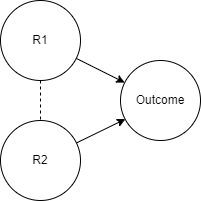

As discussed on the risk correlation page, the correlation between R1 and R2 affects the calculation of the PAF of R1 and R2 on the outcome. If we are modeling the impact of an intervention that affects R1 and/or R2, failing to consider the correlation between R1 and R2 will likewise affect our estimation of the impact of the intervention on the outcome. 

Note that when the correlation between two (or more) risks that affect the same outcome is modeled within a vivarium simulation, the risk-correlation-aware PAF calculation described on the main risk-risk correlation documentation page should be used.

In [5]:
"""
Calculates absolute error in the PAF and in cases of the outcome averted as if we fail 
to consider correlation between R1 and R2 as a proportion of the PAF and cases averted
estimates when correlation is considered. Calculation performed under the assumption of
the given input parameter values and dichotomous R1 and R2 distributions.
"""

def calculate_paf_and_outcome_bias_dichotomous_risks(r1_exp, r1_rr, r2_exp, r2_rr, rho,
                                                    int_r1_rr, int_r2_rr, # defined as intervention influence
                                                                          # on population risk exposure
                                                     N, O_rate):
    np.random.seed(1)
    df = pd.DataFrame(index=range(N))
    probit_propensity = np.random.multivariate_normal([0,0], [[1, rho], [rho, 1]], size=N)
    propensity = scipy.stats.norm().cdf(probit_propensity)
    df['r1'] = np.where(propensity[:,0] <= r1_exp, 1, 0)
    df['r1_post'] = np.where(propensity[:,0] <= r1_exp * int_r1_rr, 1, 0)

    df['r2_correlated'] = np.where(propensity[:,1] <= r2_exp, 1, 0)
    df['r2_correlated_post'] = np.where(propensity[:,1] <= r2_exp * int_r2_rr, 1, 0)
    r2_propensities_shuffled = propensity[:,1]
    np.random.shuffle(r2_propensities_shuffled) 
    # shuffling propensities rather than randomly resampling to ensure exactly the same marginal R2 exposure distribution
    df['r2_uncorrelated'] = np.where(r2_propensities_shuffled <= r2_exp, 1, 0)
    df['r2_uncorrelated_post'] = np.where(r2_propensities_shuffled <= r2_exp * int_r2_rr, 1, 0)

    df['r1_rr'] = np.where(df.r1 == 1, r1_rr, 1)
    df['r2_rr_correlated'] = np.where(df.r2_correlated == 1, r2_rr, 1)
    df['r2_rr_uncorrelated'] = np.where(df.r2_uncorrelated == 1, r2_rr, 1)
    df['joint_rr_correlated'] = df.r1_rr * df.r2_rr_correlated
    df['joint_rr_uncorrelated'] = df.r1_rr * df.r2_rr_uncorrelated
    paf_correlated = (df.joint_rr_correlated.mean() - 1) / df.joint_rr_correlated.mean()
    paf_uncorrelated = (df.joint_rr_uncorrelated.mean() - 1) / df.joint_rr_uncorrelated.mean()
    
    df['O_correlated'] = O_rate * (1 - paf_correlated) * df.joint_rr_correlated
    df['O_uncorrelated'] = O_rate * (1 - paf_uncorrelated) * df.joint_rr_uncorrelated

    df['r1_rr'] = np.where(df.r1_post == 1, r1_rr, 1)
    df['r2_rr_correlated'] = np.where(df.r2_correlated_post == 1, r2_rr, 1)
    df['r2_rr_uncorrelated'] = np.where(df.r2_uncorrelated_post == 1, r2_rr, 1)

    df['joint_rr_correlated'] = df.r1_rr * df.r2_rr_correlated
    df['joint_rr_uncorrelated'] = df.r1_rr * df.r2_rr_uncorrelated
    df['O_correlated'] = O_rate * (1 - paf_correlated) * df.joint_rr_correlated
    df['O_uncorrelated'] = O_rate * (1 - paf_uncorrelated) * df.joint_rr_uncorrelated

    O_averted_correlated = O_rate - df.O_correlated.mean()
    O_averted_uncorrelated = O_rate - df.O_uncorrelated.mean()

    O_bias_absolute = O_averted_uncorrelated - O_averted_correlated
    O_bias_relative = O_bias_absolute / O_averted_correlated
    
    # NOTE: PAF bias is not returned, but can be assessed according to this equation
    paf_bias = (paf_uncorrelated - paf_correlated) / paf_correlated
    
    return O_bias_absolute, O_bias_relative

In [9]:
# here, the intervention affects both R1 and R2

calculate_paf_and_outcome_bias_dichotomous_risks(r1_exp=0.5, r1_rr=2, r2_exp=0.5, r2_rr=2, rho=0.5,
                                                    int_r1_rr=0.5, int_r2_rr=0.5, N=10_000, O_rate=0.1)

    # we would underestimate cases averted by ~24 per 100,000 person-years in this case
    # by failing to consider the correlation between R1 and R2, approximately a 0.8% underestimate
    # of the value if we were to consider the correlation

(-0.00023926361394559226, -0.007918933952998584)

In [10]:
# here, the intervention affects only R1 with no effect on R2

calculate_paf_and_outcome_bias_dichotomous_risks(r1_exp=0.5, r1_rr=2, r2_exp=0.5, r2_rr=2, rho=0.5,
                                                    int_r1_rr=0.5, int_r2_rr=1, N=10_000, O_rate=0.1)

    # magnitude of bisa increases here

(-0.000455934995705079, -0.027182069953751966)

Text(0.5, 0, 'R1 exposure')

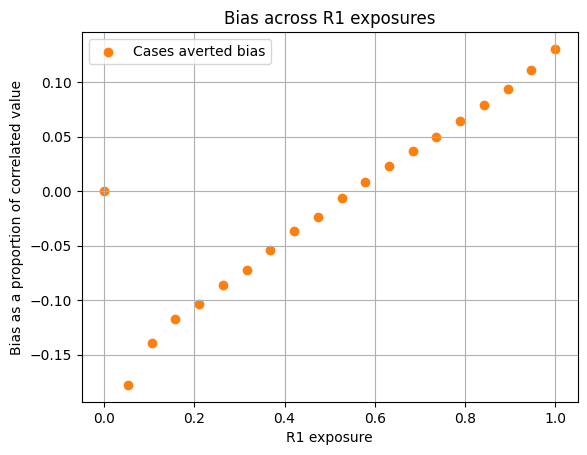

In [13]:
plt.figure()
for val in np.linspace(0, 1, 20):
    abs_bias, rel_bias = calculate_paf_and_outcome_bias_dichotomous_risks(r1_exp=val, r1_rr=2, r2_exp=0.5, r2_rr=2, rho=0.5,
                                                    int_r1_rr=0.5, int_r2_rr=1, N=100_000, O_rate=0.1)
    #plt.scatter(val, abs_bias, color='tab:blue')
    plt.scatter(val, rel_bias, color='tab:orange')
plt.grid()
plt.title('Bias across R1 exposures')
plt.legend(['Cases averted bias'])
plt.ylabel('Bias as a proportion of correlated value')
plt.xlabel('R1 exposure')

Text(0.5, 0, 'Rho')

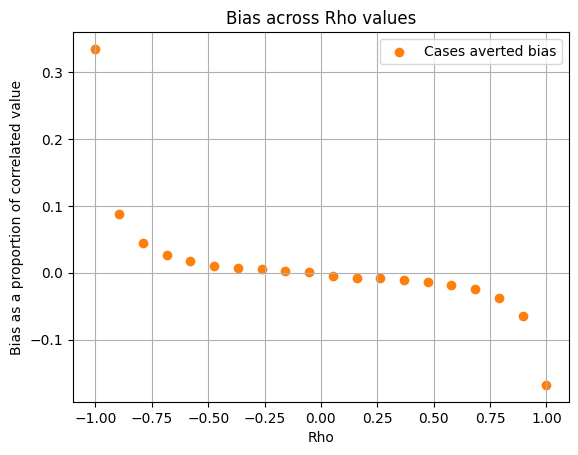

In [16]:
# intervention affects R1 only (not R2)

plt.figure()
for val in np.linspace(-1, 1, 20):
    abs_bias, rel_bias = calculate_paf_and_outcome_bias_dichotomous_risks(r1_exp=0.5, r1_rr=2, r2_exp=0.5, r2_rr=2, rho=val,
                                                    int_r1_rr=0.5, int_r2_rr=1, N=100_000, O_rate=0.1)
    plt.scatter(val, rel_bias, color='tab:orange')
plt.grid()
plt.title('Bias across Rho values')
plt.legend(['Cases averted bias'])
plt.ylabel('Bias as a proportion of correlated value')
plt.xlabel('Rho')

Text(0.5, 0, 'Rho')

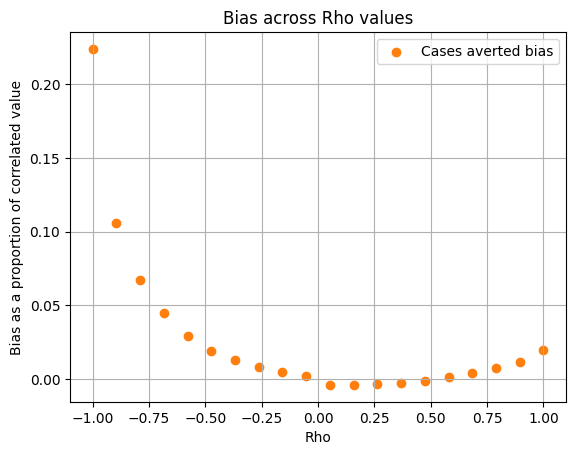

In [17]:
# intervention affects R1 and R2

plt.figure()
for val in np.linspace(-1, 1, 20):
    abs_bias, rel_bias = calculate_paf_and_outcome_bias_dichotomous_risks(r1_exp=0.5, r1_rr=2, r2_exp=0.5, r2_rr=2, rho=val,
                                                    int_r1_rr=0.5, int_r2_rr=0.5, N=100_000, O_rate=0.1)
    plt.scatter(val, rel_bias, color='tab:orange')
plt.grid()
plt.title('Bias across Rho values')
plt.legend(['Cases averted bias'])
plt.ylabel('Bias as a proportion of correlated value')
plt.xlabel('Rho')

In [27]:
# now for continuous risks

"""
Calculates absolute error in the PAF and in cases of the outcome averted as if we fail 
to consider correlation between R1 and R2 as a proportion of the PAF and cases averted
estimates when correlation is considered. Calculation performed under the assumption of
the given input parameter values and continuous normal distributions of R1 and R2.
"""

def calculate_paf_and_cases_averted_bias(r1_mean,
                                        r1_sd,
                                        r1_tmrel,
                                        r1_rr,
                                        
                                        r2_mean,
                                        r2_sd,
                                        r2_tmrel,
                                        r2_rr,
                                        
                                        rho,
                                        
                                        r1_delta,
                                        r2_delta,
                                        
                                        N,
                                        O_rate):
    np.random.seed(1)
    df = pd.DataFrame(index=range(N))
    probit_propensity = np.random.multivariate_normal([0,0], [[1, rho], [rho, 1]], size=N)
    propensity = scipy.stats.norm().cdf(probit_propensity)
    df['r1'] = scipy.stats.norm(r1_mean, r1_sd).ppf(propensity[:,0])
    df['r2_correlated'] = scipy.stats.norm(r2_mean, r2_sd).ppf(propensity[:,1])
    r2_propensities_shuffled = propensity[:,1]
    np.random.shuffle(r2_propensities_shuffled) 
    # shuffling propensities rather than randomly resampling to ensure exactly the same marginal R2 exposure distribution
    df['r2_uncorrelated'] = scipy.stats.norm(r2_mean, r2_sd).ppf(r2_propensities_shuffled)

    df['r1_rr'] = np.where(df.r1 < r1_tmrel, 1, r1_rr ** (df.r1 - r1_tmrel))
    df['r2_rr_correlated'] = np.where(df.r2_correlated < r2_tmrel, 1, r2_rr ** (df.r2_correlated - r2_tmrel))
    df['r2_rr_uncorrelated'] = np.where(df.r2_uncorrelated < r2_tmrel, 1, r2_rr ** (df.r2_uncorrelated - r2_tmrel))
    df['joint_rr_correlated'] = df.r1_rr * df.r2_rr_correlated
    df['joint_rr_uncorrelated'] = df.r1_rr * df.r2_rr_uncorrelated
    paf_correlated = (df.joint_rr_correlated.mean() - 1) / df.joint_rr_correlated.mean()
    paf_uncorrelated = (df.joint_rr_uncorrelated.mean() - 1) / df.joint_rr_uncorrelated.mean()
    paf_bias = (paf_uncorrelated - paf_correlated) / paf_correlated

    df['O_correlated'] = O_rate * (1 - paf_correlated) * df.joint_rr_correlated
    df['O_uncorrelated'] = O_rate * (1 - paf_uncorrelated) * df.joint_rr_uncorrelated

    df['r1'] = df.r1 - r1_delta
    df['r2_correlated'] = df.r2_correlated - r2_delta
    df['r2_uncorrelated'] = df.r2_uncorrelated - r2_delta

    df['r1_rr'] = np.where(df.r1 < r1_tmrel, 1, r1_rr ** (df.r1 - r1_tmrel))
    df['r2_rr_correlated'] = np.where(df.r2_correlated < r2_tmrel, 1, r2_rr ** (df.r2_correlated - r2_tmrel))
    df['r2_rr_uncorrelated'] = np.where(df.r2_uncorrelated < r2_tmrel, 1, r2_rr ** (df.r2_uncorrelated - r2_tmrel))

    df['joint_rr_correlated'] = df.r1_rr * df.r2_rr_correlated
    df['joint_rr_uncorrelated'] = df.r1_rr * df.r2_rr_uncorrelated
    df['O_correlated'] = O_rate * (1 - paf_correlated) * df.joint_rr_correlated
    df['O_uncorrelated'] = O_rate * (1 - paf_uncorrelated) * df.joint_rr_uncorrelated

    O_averted_correlated = O_rate - df.O_correlated.mean()
    O_averted_uncorrelated = O_rate - df.O_uncorrelated.mean()

    O_bias_absolute = O_averted_uncorrelated - O_averted_correlated
    O_bias_relative = O_bias_absolute / O_averted_correlated
    
    paf_bias = (paf_uncorrelated - paf_correlated) / paf_correlated

    return paf_bias, O_bias_relative

# the PAF bias is returned here so in order to demonstrate in the following 
# following plots that the PAF bias is not always similar in magnitude 
# to the magnitude of the bias in the estimate of outcome cases averted

# select returned outcomes as appropriate to fit your needs

In [28]:
# define default parameters

r1_mean=10 
r1_sd=2 
r1_tmrel=8 
r1_rr=1.2

r2_mean=10 
r2_sd=2 
r2_tmrel=8 
r2_rr=1.2

rho= 0.8

r1_delta=2 
r2_delta=2
r1_threshold=10

N=1_000_000 

O_rate = 0.2

In [29]:
calculate_paf_and_cases_averted_bias(r1_mean,
                                        r1_sd,
                                        r1_tmrel,
                                        r1_rr,
                                        
                                        r2_mean,
                                        r2_sd,
                                        r2_tmrel,
                                        r2_rr,
                                        
                                        rho,
                                        
                                        r1_delta,
                                        r2_delta,
                                        
                                        N,
                                        O_rate)

# as discussed on the risk correlation page, in the presence of positive correlation
# between R1 and R2 and RRs>1 for the effects of R1 and R2 on O, we will always have a 
# net underestimate of the PAF.

# here, the PAF error is similar in magnitude to the error in the estimate of cases averted
    # however, that is not always the case

(-0.05699689521795421, -0.05463124727850567)

Text(0.5, 0, 'Rho')

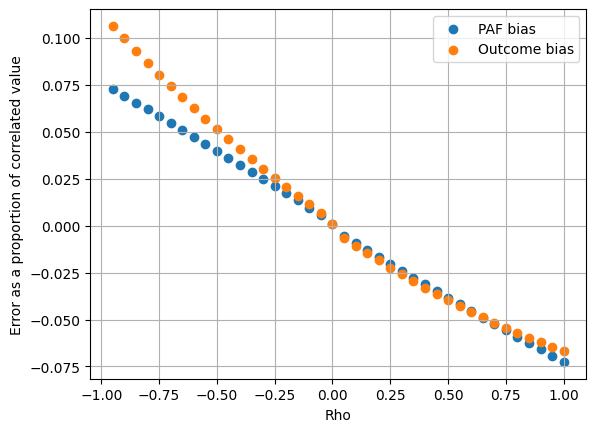

In [30]:
for val in np.linspace(-0.95, 1, 40):
    result = calculate_paf_and_cases_averted_bias(r1_mean,
                                        r1_sd,
                                        r1_tmrel,
                                        r1_rr,
                                        
                                        r2_mean,
                                        r2_sd,
                                        r2_tmrel,
                                        r2_rr,
                                        
                                        val,
                                        
                                        r1_delta,
                                        r2_delta,
                                                  
                                        N=10_000,
                                        O_rate=0.1)
    plt.scatter(val, result[0], color='tab:blue')
    plt.scatter(val, result[1], color='tab:orange')
plt.grid()
plt.legend(['PAF bias','Outcome bias'])
plt.ylabel('Error as a proportion of correlated value')
plt.xlabel('Rho')

Text(0.5, 0, 'R1 delta')

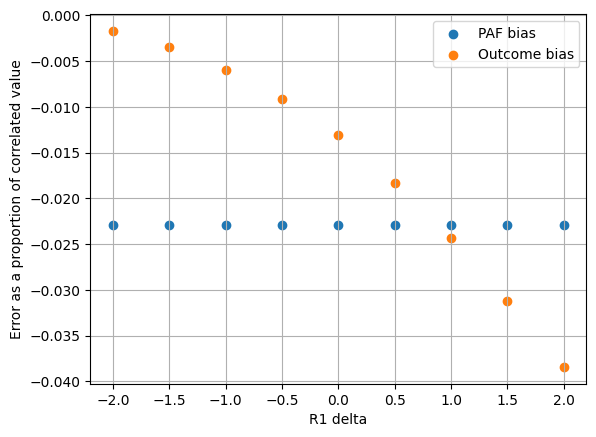

In [31]:
for val in np.linspace(-2, 2, num=9):
    result = calculate_paf_and_cases_averted_bias(r1_mean=10,
                                        r1_sd=2,
                                        r1_tmrel=8,
                                        r1_rr=1.1,
                                        
                                        r2_mean=10,
                                        r2_sd=2,
                                        r2_tmrel=8,
                                        r2_rr=1.5,
                                        
                                        rho=0.5,
                                        
                                        r1_delta=val,
                                        r2_delta=1,
                                                  
                                        N=10_000,
                                        O_rate=0.1)
    plt.scatter(val, result[0], color='tab:blue')
    plt.scatter(val, result[1], color='tab:orange')
plt.grid()
plt.legend(['PAF bias','Outcome bias'])
plt.ylabel('Error as a proportion of correlated value')
plt.xlabel('R1 delta')